# Variational Quantum Eigensolver

1. Find the molecular Hamiltonian
2. Prepare trial ground state -> ansatze 
3. Minimize the Hamiltonian expectation value 

In [21]:
from sympy import Matrix
from sympy.printing.latex import latex

from nablaDFT.dataset import HamiltonianDatabase

train = HamiltonianDatabase("train_2k.db.1")
# atoms numbers, atoms positions, energy, forces, core hamiltonian, overlap matrix, coefficients matrix,
# moses_id, conformation_id
Z, R, E, F, H, S, C, moses_id, conformation_id = train[0]

In [22]:
print(E)

[-1059.0074]


In [23]:
print(len(H), 'x', len(H[0]))


402 x 402


In [24]:
import scipy

# Calculate eigenvalues and eigenvectors of H
eigenvalues, eigenvectors = scipy.linalg.eig(H)
print(min(eigenvalues))

(-23.17431+0j)


[[5.385329891594017, 4.549810234508412, 1.5772312777469688, 0.3994771729106249, 4.835365297555476, 0.24965571463386318, 2.115109121808859, 0.7336207116846056, 1.0375163794451225, 2.7712628894613585, 4.805641756386443, 0.13715387098779916, 3.664018078646276, 1.0617811824568715, 5.40990832548694, 6.035133500171826, 5.817662288162314, 0.6879127450036137, 0.6148646591258047, 0.7979184201703287, 3.633316416497843, 3.5441516062600975, 4.977552411618247, 4.280828630453413, 2.356974266984819, 6.246665240102233, 0.33038130746827793, 6.141548227538218, 3.271042119471034, 0.47488082279278054, 3.4665194800275927, 0.8385542375085815, 6.124349459885351, 0.5859195199690289, 1.4123452867059516, 4.825211165573993]]


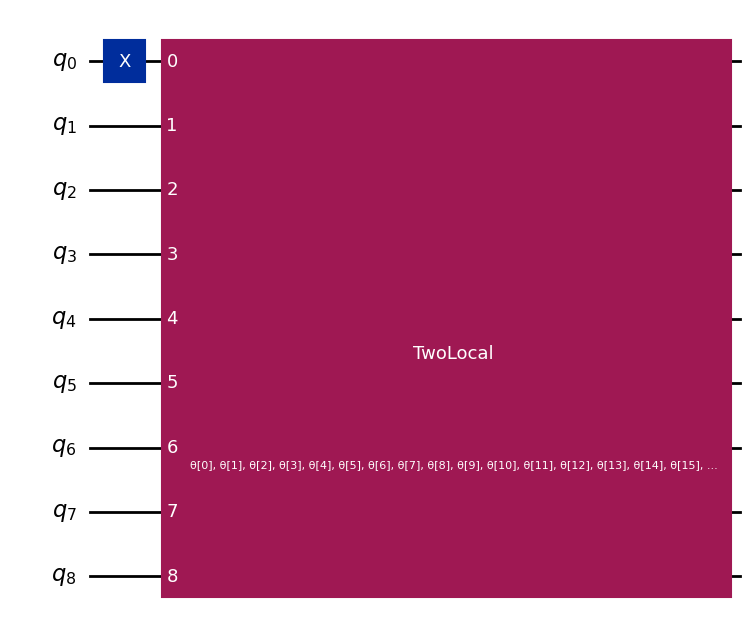

In [25]:
from qiskit.quantum_info import SparsePauliOp, Operator
import numpy as np
# Convert the matrix to an Operator
H_original = H 
H_mapped = np.zeros((512, 512))
H_mapped[:402, :402] = H_original
operator = Operator(H_mapped)
#Convert the Operator to a SparsePauliOp
sparse_pauli_op = SparsePauliOp.from_operator(operator)

#print(sparse_pauli_op)

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

'''theta_list = (2 * np.pi * np.random.rand(1, 36)).tolist()'''
#observable=SparsePauliOp.from_list([("II", 0.5), ("XX", -0.5), ("YY", -0.5), ("ZZ", 0.5)])

reference_circuit = QuantumCircuit(9)
#reference_circuit.x(0)

variational_form = TwoLocal(
    9,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=3,
)
ansatz = reference_circuit.compose(variational_form)
print(theta_list)
ansatz.draw('mpl')


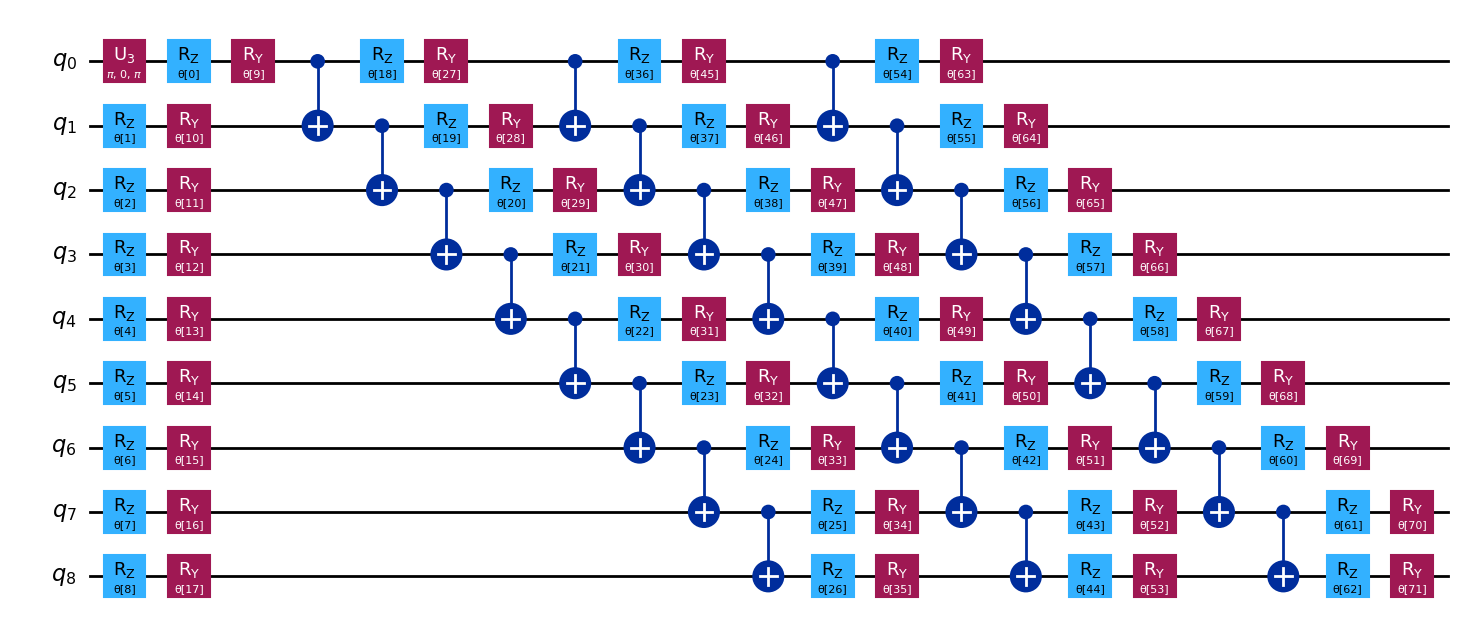

In [32]:
ansatz.decompose().draw('mpl')

In [26]:
eigenvalues_mapped, eigenvectors_mapped = scipy.linalg.eig(H_mapped)
print(min(eigenvalues_mapped))

(-23.17432034817615+0j)


In [27]:
def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    return cost

In [28]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()
x0 = np.random.uniform(low=0, high=2*np.pi, size=72)
print(x0) 

[0.0765808  1.65586628 2.23834253 4.78269481 6.04600934 5.5815387
 5.49835253 0.1979518  2.20811106 4.68036846 0.23723084 3.47283279
 0.38708317 2.81395461 0.56735631 2.74096107 4.31410343 2.9817875
 4.85522187 3.16717119 0.5419637  0.9685382  4.38648182 1.23541957
 2.68388196 3.49420756 0.95264726 5.27821491 1.2050667  4.87132689
 4.42606438 4.20531913 1.08595378 2.86449362 0.91195547 6.02367553
 2.50738845 1.56039321 0.71995497 3.27131919 0.72232441 4.77265465
 1.46426356 3.19793946 0.02093657 4.94143254 0.34119985 4.48339136
 3.49158313 0.20852641 5.69139285 1.71976071 3.12357087 4.26436541
 1.66953834 0.4539259  0.78029514 4.95845455 0.97020071 4.37395682
 1.87740483 5.23153936 0.44896795 5.23254469 0.3578559  2.47645385
 4.33620626 0.49069868 4.14783016 1.38913083 4.81476438 2.02367963]


In [29]:
# SciPy minimizer routine
from scipy.optimize import minimize



result = minimize(cost_func_vqe, x0, args=(ansatz, sparse_pauli_op, estimator), method="COBYLA",options={'maxiter': 12000})

result

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -16.854852919494025
       x: [ 9.905e-01  2.518e+00 ...  4.713e+00  1.910e+00]
    nfev: 12000
   maxcv: 0.0

In [30]:
print(result.x)

[ 9.90536864e-01  2.51822157e+00  2.37511695e+00  3.27418062e+00
  6.14371962e+00  6.57702500e+00  5.64654562e+00  1.13494279e+00
  3.22598247e+00  4.78872928e+00  4.33986615e-02  4.71842089e+00
 -4.29756677e-04  2.42335034e+00  8.16751752e-01  3.07056845e+00
  4.70086693e+00  1.57143469e+00  3.97288190e+00  2.34338696e+00
  1.52281923e+00  7.52339997e-01  5.29022192e+00  1.60987421e+00
  3.02781527e+00  3.14947975e+00  1.57126449e+00  5.87334985e+00
  4.17894387e-01  4.70953387e+00  4.70934149e+00  3.15058635e+00
  1.56813739e+00  3.88878393e+00  1.06634986e-02  5.91634788e+00
  3.09976101e+00  2.09063388e+00 -5.83258666e-03  4.55912954e+00
  2.55639420e+00  4.71688882e+00  1.56845148e+00  3.14130556e+00
  7.95659420e-01  4.63312669e+00 -1.20439093e-02  4.70862053e+00
  3.14198689e+00  8.13630881e-01  4.77466951e+00  1.91746106e+00
  3.59760092e+00  4.71358970e+00 -6.88341086e-01  1.26117178e+00
  3.04853820e+00  4.55998437e+00  9.21981944e-01  3.14203422e+00
  1.89573431e+00  4.71313

In [31]:
print(result.fun)

-16.854852919494025
